# Project: Image Classification and Regression

#### Jeremi Assael

## 1. Sending your answers

## 2. Getting started

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
# from keras.callbacks import EarlyStopping
# from keras import initializers

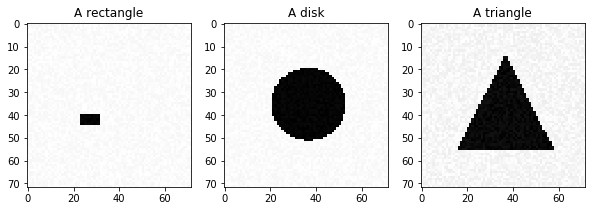

In [5]:
%matplotlib inline


# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]



plt.subplots(1,3,figsize=(10,10))
plt.subplot(131)
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("A rectangle")

plt.subplot(132)
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("A disk")

plt.subplot(133)
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("A triangle")


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



## 3. Simple classification

##### Generating the training set

In [90]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

y_train = to_categorical(Y_train)

Creating data:
0
100
200


### 3.1. Using SGD optimizer in a linear classifier

In [94]:
model_sgd = Sequential()
model_sgd.add(Dense(3, input_shape=(5184,), activation='softmax'))

sgd = SGD(lr=0.01, decay=0, momentum=0, nesterov=False)

model_sgd.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
model_sgd.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
300/300 [==============================] - 1s 3ms/step - loss: 7.6006 - acc: 0.3733
Epoch 2/50
300/300 [==============================] - 0s 160us/step - loss: 8.3092 - acc: 0.3467
Epoch 3/50
300/300 [==============================] - 0s 133us/step - loss: 8.7220 - acc: 0.3367
Epoch 4/50
300/300 [==============================] - 0s 186us/step - loss: 10.9603 - acc: 0.3200
Epoch 5/50
300/300 [==============================] - 0s 173us/step - loss: 10.9603 - acc: 0.3200
Epoch 6/50
300/300 [==============================] - 0s 186us/step - loss: 10.9603 - acc: 0.3200
Epoch 7/50
300/300 [==============================] - 0s 213us/step - loss: 10.9603 - acc: 0.3200
Epoch 8/50
300/300 [==============================] - 0s 173us/step - loss: 10.9603 - acc: 0.3200
Epoch 9/50
300/300 [==============================] - 0s 186us/step - loss: 10.9603 - acc: 0.3200
Epoch 10/50
300/300 [==============================] - 0s 173us/step - loss: 10.9603 - acc: 0.3200
Epoch 11/50
300/300 [===

##### Testing the model

For the test, we can note that the categoricals are:
- 0 for a rectangle
- 1 for a disk
- 2 for a triangle

In [83]:
def shape_name(array):
    """Function to print the name of the predicted shape"""
    i = np.argmax(array)
    if i == 0:
        print("The prediction is a rectangle.")
    elif i == 1:
        print("The prediction is a disk.")
    else:
        print("The prediction is a triangle.")

In [39]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
prediction_array = model_sgd.predict(X_test)
print("Prediction array:", prediction_array)
print("The real figure is a rectangle")
shape_name(prediction_array)

[[1. 0. 0.]]
The real figure is a rectangle
The prediction is a rectangle.


In [37]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
prediction_array = model_sgd.predict(X_test)
print("Prediction array:", prediction_array)
print("The real figure is a disk")
shape_name(prediction_array)

[[1. 0. 0.]]
The prediction is a rectangle.


In [38]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
prediction_array = model_sgd.predict(X_test)
print("Prediction array:", prediction_array)
print("The real figure is a triangle")
shape_name(prediction_array)

[[0. 0. 1.]]
The prediction is a triangle.


Our network is having a hard time classifying the different shapes. The loss is often stuck in local minimas preventing the network to learn more. The lowest loss I managed to achieve with this network is around 5.1 for an accuracy of 0.68 (on the training set) but most of the time training will result in worst results, even worst than random with a loss around 11 and an accuracy of 0.32 (on the training set).

### 3.2. Using Adam optimizer in a linear classifier

In [93]:
model_adam = Sequential()
model_adam.add(Dense(3, input_shape=(5184,), activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_adam.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
model_adam.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
300/300 [==============================] - 1s 3ms/step - loss: 1.6167 - acc: 0.4433
Epoch 2/30
300/300 [==============================] - 0s 146us/step - loss: 0.8948 - acc: 0.6033
Epoch 3/30
300/300 [==============================] - 0s 120us/step - loss: 0.5804 - acc: 0.7667
Epoch 4/30
300/300 [==============================] - 0s 173us/step - loss: 0.4218 - acc: 0.8200
Epoch 5/30
300/300 [==============================] - 0s 200us/step - loss: 0.3960 - acc: 0.8367
Epoch 6/30
300/300 [==============================] - 0s 200us/step - loss: 0.2999 - acc: 0.9000
Epoch 7/30
300/300 [==============================] - 0s 240us/step - loss: 0.2452 - acc: 0.9700
Epoch 8/30
300/300 [==============================] - 0s 200us/step - loss: 0.2243 - acc: 0.9700
Epoch 9/30
300/300 [==============================] - 0s 186us/step - loss: 0.2327 - acc: 0.9233
Epoch 10/30
300/300 [==============================] - 0s 186us/step - loss: 0.1779 - acc: 0.9900
Epoch 11/30
300/300 [==========

##### Testing the model

In [84]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
prediction_array = model_adam.predict(X_test)
print("Prediction array:", prediction_array)
print("The real figure is a rectangle")
shape_name(prediction_array)

Prediction array: [[1. 0. 0.]]
The real figure is a rectangle
The prediction is a rectangle.


In [85]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
prediction_array = model_adam.predict(X_test)
print("Prediction array:", prediction_array)
print("The real figure is a disk")
shape_name(prediction_array)

Prediction array: [[0. 1. 0.]]
The real figure is a disk
The prediction is a disk.


In [86]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0])
prediction_array = model_adam.predict(X_test)
print("Prediction array:", prediction_array)
print("The real figure is a triangle")
shape_name(prediction_array)

Prediction array: [[0. 0. 1.]]
The real figure is a triangle
The prediction is a triangle.


The Adam optimizer works way better than the SGD one. We can achieve a loss around 0.05 and an accuracy of 1 on the training set, meaning our network successfully classified each shape. We shoud however evaulate the performance of our trained network on a test set to be sure that it did not overfit (even though we trained it for a relatively small number of epochs).

## 4. Visualization of the solution

### 4.1. Using SGD optimizer

Text(0.5,1,'Weights for the triangle shape')

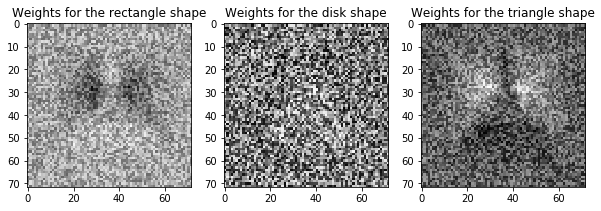

In [40]:
plt.subplots(1,3, figsize=(10,10))

weights_sgd = model_sgd.get_weights()
weights_sgd_rectangle = weights_sgd[0][:,0]
plt.subplot(131)
plt.imshow(weights_sgd_rectangle.reshape(72,72), cmap='gray')
plt.title("Weights for the rectangle shape")

weights_sgd = model_sgd.get_weights()
weights_sgd_disk = weights_sgd[0][:,1]
plt.subplot(132)
plt.imshow(weights_sgd_disk.reshape(72,72), cmap='gray')
plt.title("Weights for the disk shape")

weights_sgd = model_sgd.get_weights()
weights_sgd_triangle = weights_sgd[0][:,2]
plt.subplot(133)
plt.imshow(weights_sgd_triangle.reshape(72,72), cmap='gray')
plt.title("Weights for the triangle shape")

The darker the pixel, the lower is the weight associated with this pixel. 

We can see that our SGD linear classifier does not succeed in capturing the caratheristics of the shapes, especially for the disk. If we try to train the network several times, the best result for this network is to learn (with limited results) the caractheristics of two shapes. It failed to learn anaything about the last one.

### 4.2. Using Adam optimizer

Text(0.5,1,'Weights for the triangle shape')

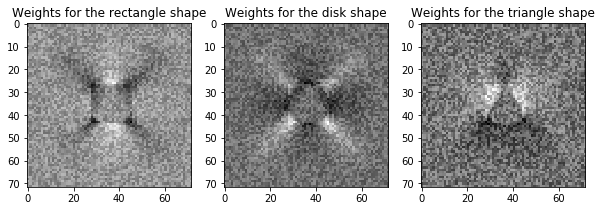

In [644]:
plt.subplots(1,3, figsize=(10,10))

weights_adam = model_adam.get_weights()
weights_adam_rectangle = weights_adam[0][:,0]
plt.subplot(131)
plt.imshow(weights_adam_rectangle.reshape(72,72), cmap='gray')
plt.title("Weights for the rectangle shape")

weights_adam = model_adam.get_weights()
weights_adam_disk = weights_adam[0][:,1]
plt.subplot(132)
plt.imshow(weights_adam_disk.reshape(72,72), cmap='gray')
plt.title("Weights for the disk shape")

weights_adam = model_adam.get_weights()
weights_adam_triangle = weights_adam[0][:,2]
plt.subplot(133)
plt.imshow(weights_adam_triangle.reshape(72,72), cmap='gray')
plt.title("Weights for the triangle shape")

The darker the pixel, the lower is the weight associated with this pixel.

The weights for the Adam linear classifier proves that our network succeed to learn the caractheristics of the shapes. The network focus on finding the features with the higher weights to discriminate a shape from the others.

## 5. A More Diffcult Classification Problem

##### Generating the training and test sets

In [107]:
[X_train, Y_train] = generate_dataset_classification(400, 20, True)
[X_test, Y_test] = generate_test_set_classification()
y_train = to_categorical(Y_train)

Creating data:
0
100
200
300
Creating data:
0
100
200


### 5.1. Previous linear classifiers

#### 5.1.1. SGD

In [68]:
model_sgd_move = Sequential()
model_sgd_move.add(Dense(3, input_shape=(5184,), activation='softmax'))

sgd = SGD(lr=0.01, decay=0, momentum=0, nesterov=False)

model_sgd_move.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])
model_sgd_move.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
400/400 [==============================] - 1s 2ms/step - loss: 8.6875 - acc: 0.3250
Epoch 2/100
400/400 [==============================] - 0s 130us/step - loss: 9.0988 - acc: 0.3350
Epoch 3/100
400/400 [==============================] - 0s 140us/step - loss: 9.2804 - acc: 0.3125
Epoch 4/100
400/400 [==============================] - 0s 150us/step - loss: 8.1547 - acc: 0.3550
Epoch 5/100
400/400 [==============================] - 0s 130us/step - loss: 8.6879 - acc: 0.3400
Epoch 6/100
400/400 [==============================] - 0s 150us/step - loss: 7.9584 - acc: 0.3500
Epoch 7/100
400/400 [==============================] - 0s 140us/step - loss: 7.1887 - acc: 0.4425
Epoch 8/100
400/400 [==============================] - 0s 130us/step - loss: 6.9864 - acc: 0.4300
Epoch 9/100
400/400 [==============================] - 0s 120us/step - loss: 7.2186 - acc: 0.4250
Epoch 10/100
400/400 [==============================] - 0s 140us/step - loss: 6.6997 - acc: 0.4675
Epoch 11/100
400/400 

In [69]:
evaluation = model_sgd_move.evaluate(X_test, Y_test, verbose=0)
print("Loss on the test set:", evaluation[0])
print("Accuracy on the test set:", evaluation[1])

Loss on the test set: 5.8065321858723955
Accuracy on the test set: 0.5299999996026357


The SGD linear classifier which already struggled to learn anything when the shapes were at fixed positions completely fails here to learn anything. The results are equivalent to a random classifier.

#### 5.1.2. Adam

In [80]:
model_adam_move = Sequential()
model_adam_move.add(Dense(3, input_shape=(5184,), activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_adam_move.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
model_adam_move.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
400/400 [==============================] - 1s 2ms/step - loss: 1.7496 - acc: 0.3975
Epoch 2/50
400/400 [==============================] - 0s 140us/step - loss: 1.1241 - acc: 0.4250
Epoch 3/50
400/400 [==============================] - 0s 130us/step - loss: 1.0137 - acc: 0.5100
Epoch 4/50
400/400 [==============================] - 0s 140us/step - loss: 0.9578 - acc: 0.5175
Epoch 5/50
400/400 [==============================] - 0s 150us/step - loss: 0.8286 - acc: 0.6300
Epoch 6/50
400/400 [==============================] - 0s 130us/step - loss: 0.7797 - acc: 0.6475
Epoch 7/50
400/400 [==============================] - 0s 130us/step - loss: 0.8247 - acc: 0.6350
Epoch 8/50
400/400 [==============================] - 0s 150us/step - loss: 0.8951 - acc: 0.5375
Epoch 9/50
400/400 [==============================] - 0s 140us/step - loss: 0.9085 - acc: 0.6150
Epoch 10/50
400/400 [==============================] - 0s 130us/step - loss: 0.7601 - acc: 0.6450
Epoch 11/50
400/400 [==========

In [115]:
evaluation = model_adam_move.evaluate(X_test, Y_test, verbose=0)
print("Loss on the test set:", evaluation[0])
print("Accuracy on the test set:", evaluation[1])

Loss on the test set: 1.1015023072560628
Accuracy on the test set: 0.6133333325386048


The Adam linear classifier performs better than the SGD linear classifier but is still not as good as desired as it fails to correctly classifies one third of the training set and then an even bigger proportion of the test set.

### 5.2. Using a CNN

##### Reshaping the data to be used as input for our CNN

In [117]:
x_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
x_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

In [109]:
x_train.shape

(400, 72, 72, 1)

##### Our model

In [121]:
model_cnn = Sequential()


model_cnn.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(32, (5, 5), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(3, activation='softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_cnn.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
model_cnn.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.25)

Train on 300 samples, validate on 100 samples
Epoch 1/25
300/300 [==============================] - 4s 12ms/step - loss: 1.0803 - acc: 0.4067 - val_loss: 1.0317 - val_acc: 0.4600
Epoch 2/25
300/300 [==============================] - 2s 7ms/step - loss: 0.9562 - acc: 0.6000 - val_loss: 0.9542 - val_acc: 0.4900
Epoch 3/25
300/300 [==============================] - 2s 7ms/step - loss: 0.7891 - acc: 0.6767 - val_loss: 0.9344 - val_acc: 0.5700
Epoch 4/25
300/300 [==============================] - 2s 7ms/step - loss: 0.6257 - acc: 0.7167 - val_loss: 1.0406 - val_acc: 0.5500
Epoch 5/25
300/300 [==============================] - 2s 7ms/step - loss: 0.5323 - acc: 0.7967 - val_loss: 0.8657 - val_acc: 0.6300
Epoch 6/25
300/300 [==============================] - 2s 7ms/step - loss: 0.4754 - acc: 0.8300 - val_loss: 0.8614 - val_acc: 0.6400
Epoch 7/25
300/300 [==============================] - 2s 7ms/step - loss: 0.4397 - acc: 0.8233 - val_loss: 0.9006 - val_acc: 0.6600
Epoch 8/25
300/300 [=========

##### Evaluating our model

In [122]:
evaluation = model_cnn.evaluate(x_test, Y_test, verbose=0)
print("Loss on the test set:", evaluation[0])
print("Accuracy on the test set:", evaluation[1])

Loss on the test set: 0.64470521291097
Accuracy on the test set: 0.7899999992052714


In [123]:
test = generate_a_rectangle()
test = test.reshape(1, 72, 72, 1)
prediction_array = model_cnn.predict(test)
print("Prediction array:", prediction_array)
print("The real figure is a rectangle")
shape_name(prediction_array)

Prediction array: [[0. 1. 0.]]
The real figure is a rectangle
The prediction is a disk.


In [78]:
test = generate_a_disk()
test = test.reshape(1, 72, 72, 1)
prediction_array = model_cnn.predict(test)
print("Prediction array:", prediction_array)
print("The real figure is a disk")
shape_name(prediction_array)

Prediction array: [[0. 1. 0.]]
The real figure is a disk
The prediction is a disk.


In [79]:
test = generate_a_triangle()[0]
test = test.reshape(1, 72, 72, 1)
prediction_array = model_cnn.predict(test)
print("Prediction array:", prediction_array)
print("The real figure is a triangle")
shape_name(prediction_array)

Prediction array: [[0. 0. 1.]]
The real figure is a triangle
The prediction is a triangle.


The CNN performs better than the linear classifiers as it better succeed on building features to recognized moving shapes.

## 6. A Regression Problem

##### Generating the training and test sets

In [161]:
[X_train, Y_train] = generate_dataset_regression(400, 20)
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
100
200
300
Creating data:
0
100
200


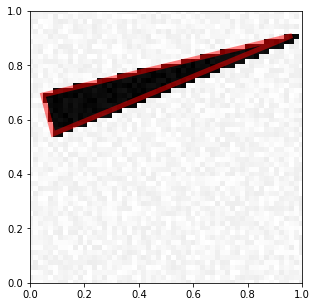

In [162]:
visualize_prediction(X_train[0], Y_train[0])

##### Reshaping the inputs and normalizing the outputs

In [163]:
x_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
x_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

We are ordering every vertex so that our network always see the regression results in the same order. We are ordering the vertices by increasing angle of the three vectors linking the gravity center of the triangle to its vertices, so that each vertice is taken into account in the trigonometric order.

In [164]:
y_train = Y_train.reshape(X_train.shape[0],3,2)
y_train_sort = np.zeros((X_train.shape[0],3,2))
for i in range(len(y_train)):
    cg = sum(y_train[i])/3
    y_train_sort[i] = sorted(y_train[i], key=lambda tuple: np.angle((tuple-cg)[0] + (tuple-cg)[1] * 1j))
y_train2 = y_train_sort.reshape(X_train.shape[0],6)


y_test = Y_test.reshape(X_test.shape[0],3,2)
y_test_sort = np.zeros((X_test.shape[0],3,2))
for i in range(len(y_test)):
    cg = sum(y_test[i])/3
    y_test_sort[i] = sorted(y_test[i], key=lambda tuple: np.angle((tuple-cg)[0] + (tuple-cg)[1] * 1j))
y_test2 = y_test_sort.reshape(X_test.shape[0],6)

##### Our model

In [165]:
model_reg = Sequential()

model_reg.add(Conv2D(50, (5, 5), activation='relu', input_shape=(72, 72, 1)))
model_reg.add(MaxPooling2D(pool_size=(2, 2)))
model_reg.add(Flatten())
model_reg.add(Dense(100, activation='relu'))
model_reg.add(Dropout(0.2))
model_reg.add(Dense(6, activation='sigmoid'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_reg.compile(loss='MSE', optimizer=adam)
model_reg.fit(x_train, y_train2, epochs=5, batch_size=32, validation_split=0.25)

Train on 300 samples, validate on 100 samples
Epoch 1/5
300/300 [==============================] - 6s 19ms/step - loss: 0.1827 - val_loss: 0.1578
Epoch 2/5
300/300 [==============================] - 3s 11ms/step - loss: 0.1035 - val_loss: 0.0462
Epoch 3/5
300/300 [==============================] - 3s 10ms/step - loss: 0.0377 - val_loss: 0.0294
Epoch 4/5
300/300 [==============================] - 3s 11ms/step - loss: 0.0275 - val_loss: 0.0269
Epoch 5/5
300/300 [==============================] - 4s 12ms/step - loss: 0.0211 - val_loss: 0.0234


##### Evaluating the model

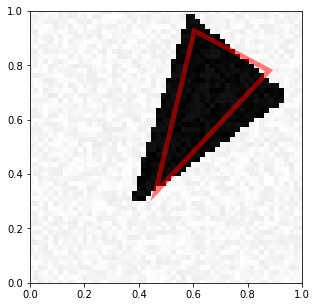

In [175]:
# u is a variable between 0 and 399 to easily choose a example of the test set and see the predicted vertices

u = 100
prediction = model_reg.predict(x_train[u:u+1])
visualize_prediction(x_train[u:u+1], prediction)

In [170]:
evaluation = model_reg.evaluate(x_test, y_test2, verbose=0)
print("Loss on the test set:", evaluation)

Loss on the test set: 0.027935277422269186


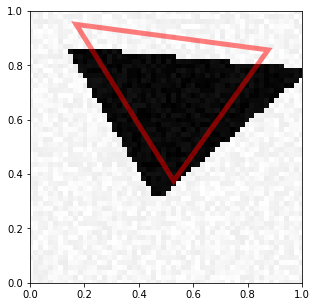

In [173]:
# u is a variable between 0 and 299 to easily choose a example of the test set and see the predicted vertices
u= 200
prediction = model_reg.predict(x_test[u:u+1])
visualize_prediction(x_test[u:u+1], prediction)

The results are not very good on the training set as well as on the test set, even though the network seems to capture some information about the position of the vertices.

## 7. Image denoising

##### Changing the functions to generate the desired dataset

We changed the functions so that a noisy image has a random noise amplitude between 0 and 200.

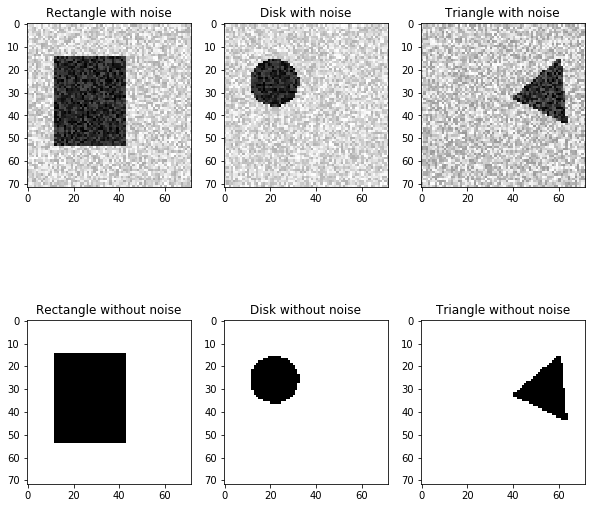

In [6]:
%matplotlib inline
IMAGE_SIZE = 72

def generate_a_noisy_drawing(figsize, U, V):
    noise = float(np.random.random(1)*200)
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    info_random = np.random.random(imdata.size)
    imdata_noisy = imdata + noise * info_random
    plt.close(fig)
    return imdata_noisy, imdata, noise

def generate_a_noisy_rectangle(free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_noisy_drawing(figsize, U, V)


def generate_a_noisy_disk(free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_noisy_drawing(figsize, U, V)

def generate_a_noisy_triangle(free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_noisy_drawing(figsize, U, V)



plt.subplots(2,3,figsize=(10,10))
im, im_noisy, noise = generate_a_noisy_rectangle(True)
plt.subplot(231)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Rectangle with noise")
plt.subplot(234)
plt.imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Rectangle without noise")

im, im_noisy, noise = generate_a_noisy_disk(True)
plt.subplot(232)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Disk with noise")
plt.subplot(235)
plt.imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Disk without noise")

im, im_noisy, noise = generate_a_noisy_triangle(True)
plt.subplot(233)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Triangle with noise")
plt.subplot(236)
plt.imshow(im_noisy.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.title("Triangle without noise")


def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i], noise = generate_a_noisy_rectangle(free_location)
        elif category == 1: 
            X[i], Y[i], noise = generate_a_noisy_disk(free_location)
        else:
            X[i], Y[i], noise = generate_a_noisy_triangle(free_location)
    Y = Y/255
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

##### Generating the training and test sets

In [7]:
[X_train, Y_train] = generate_dataset_denoising(600, free_location=True)
[X_test, Y_test] = generate_dataset_denoising(300, free_location=True)

Creating data:
0
100
200
300
400
500
Creating data:
0
100
200


In [8]:
x_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
x_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
y_train = Y_train.reshape(Y_train.shape[0], 72, 72, 1)
y_test = Y_test.reshape(Y_test.shape[0], 72, 72, 1)

##### Our model :  : a hourglass convolutionnal network

In [9]:
model_ae = Sequential()


model_ae.add(Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(72, 72, 1)))
model_ae.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_ae.add(Conv2D(8, (5, 5), activation='relu', padding='same'))
model_ae.add(UpSampling2D())
model_ae.add(Conv2D(16, (5, 5), activation='relu', padding='same'))
model_ae.add(Conv2D(1, (5, 5), activation='sigmoid', padding='same'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_ae.compile(loss='MSE', optimizer=adam)
model_ae.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.15)

Train on 510 samples, validate on 90 samples
Epoch 1/25
510/510 [==============================] - 12s 24ms/step - loss: 0.1348 - val_loss: 0.0979
Epoch 2/25
510/510 [==============================] - 12s 23ms/step - loss: 0.0891 - val_loss: 0.0935
Epoch 3/25
510/510 [==============================] - 14s 27ms/step - loss: 0.0762 - val_loss: 0.0759
Epoch 4/25
510/510 [==============================] - 14s 27ms/step - loss: 0.0646 - val_loss: 0.0615
Epoch 5/25
510/510 [==============================] - 17s 34ms/step - loss: 0.0513 - val_loss: 0.0453
Epoch 6/25
510/510 [==============================] - 13s 25ms/step - loss: 0.0380 - val_loss: 0.0373
Epoch 7/25
510/510 [==============================] - 13s 25ms/step - loss: 0.0326 - val_loss: 0.0340
Epoch 8/25
510/510 [==============================] - 13s 25ms/step - loss: 0.0305 - val_loss: 0.0325
Epoch 9/25
510/510 [==============================] - 13s 25ms/step - loss: 0.0293 - val_loss: 0.0315
Epoch 10/25
510/510 [================

##### Evaluating our model

Text(0.5,1,'Denoised image')

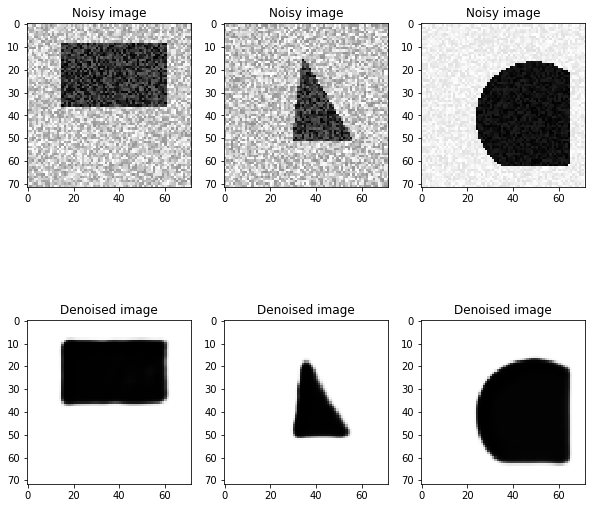

In [32]:
plt.subplots(2,3, figsize=(10,10))

prediction1 = model_ae.predict(x_train[11:12])
plt.subplot(231)
plt.imshow(x_train[11].reshape(72,72), cmap='gray')
plt.title("Noisy image")
plt.subplot(234)
plt.imshow(prediction1.reshape(72,72), cmap='gray')
plt.title("Denoised image")

prediction2 = model_ae.predict(x_train[189:190])
plt.subplot(232)
plt.imshow(x_train[189].reshape(72,72), cmap='gray')
plt.title("Noisy image")
plt.subplot(235)
plt.imshow(prediction2.reshape(72,72), cmap='gray')
plt.title("Denoised image")

prediction3 = model_ae.predict(x_train[89:90])
plt.subplot(233)
plt.imshow(x_train[89].reshape(72,72), cmap='gray')
plt.title("Noisy image")
plt.subplot(236)
plt.imshow(prediction3.reshape(72,72), cmap='gray')
plt.title("Denoised image")

In [11]:
evaluation = model_ae.evaluate(x_test, y_test, verbose=0)
print("Loss on the test set", evaluation)

Loss on the test set 0.00328136553366979


Text(0.5,1,'Denoised image')

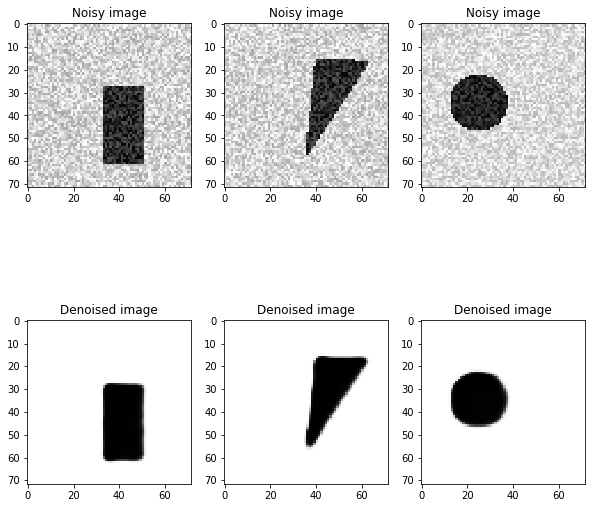

In [24]:
plt.subplots(2,3, figsize=(10,10))

prediction1 = model_ae.predict(x_test[7:8])
plt.subplot(231)
plt.imshow(x_test[7].reshape(72,72), cmap='gray')
plt.title("Noisy image")
plt.subplot(234)
plt.imshow(prediction1.reshape(72,72), cmap='gray')
plt.title("Denoised image")

prediction2 = model_ae.predict(x_test[110:111])
plt.subplot(232)
plt.imshow(x_test[110].reshape(72,72), cmap='gray')
plt.title("Noisy image")
plt.subplot(235)
plt.imshow(prediction2.reshape(72,72), cmap='gray')
plt.title("Denoised image")

prediction3 = model_ae.predict(x_test[10:11])
plt.subplot(233)
plt.imshow(x_test[10].reshape(72,72), cmap='gray')
plt.title("Noisy image")
plt.subplot(236)
plt.imshow(prediction3.reshape(72,72), cmap='gray')
plt.title("Denoised image")

Our image denoising network performs quite well.